Total number of Restaurants
48485
CSV file already exists
insignificant : 99
significant : 100
We will be training our classifier using 99 sentences from each class
OneVsRestClassifier
TfidfTransformer enabled
0.726794871795
OneVsRestClassifier
TfidfTransformer disabled
0.707692307692
LogisticRegression
TfidfTransformer enabled
0.513974358974
LogisticRegression
TfidfTransformer disabled
0.697435897436
The classifier with the highest accuracy is
OneVsRestClassifier
TfidfTransformer enabled
Lets try different combinations of min_df,max_df,binary in our classifier
the highest accuracy is:
0.746794871795
with min_df,max_df,binary as follows
1
0.2
True
Classifier built to classify sentences as significant and non siginificant
Building POS classifier
Building the word2vector


testing data shape: (28033, 18260)

confusion matrix:
          "   $  ''    (    )     ,     .    :   CC    CD ...    VB   VBD  \
"       342   0   0    0    0     0     0    0    0     0 ...     0     0   
$         0  86   0    0    0     0     0    0    0     1 ...     2     0   
''        0   0   1    0    0     0     0    0    0     0 ...     0     0   
(         0   0   0  383    0     0     0    0    0     0 ...     0     0   
)         0   0   0    0  384     0     0    0    0     0 ...     0     0   
,         0   0   0    0    0  1084     0    0    0     0 ...     0     0   
.         0   0   0    0    0     0  1017    0    0     0 ...     0     0   
:         0   0   0    0    0     0     0  258    0     0 ...     0     0   
CC        0   0   0    0    0     0     0    0  481     0 ...     0     0   
CD        0   0   0    0    0     0     0    0    0  1294 ...    14     0   
DT        0   0   0    0    0     0     0    0    0     1 ...     0     0   
EX        0   0   0  

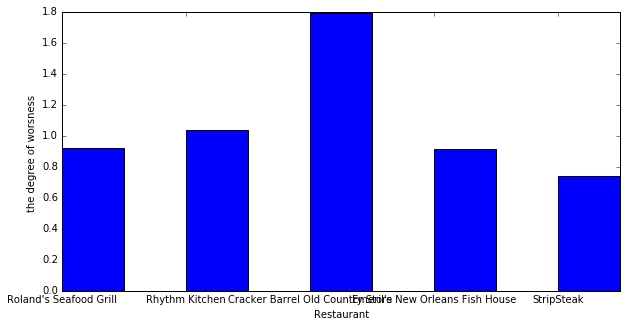

Graph for service


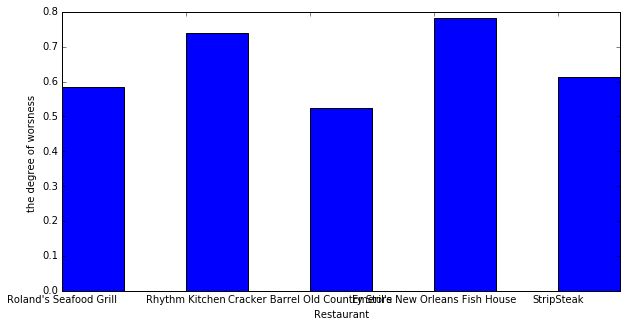

In [58]:
import simplejson as json
import json as js
import collections
import csv
import itertools
import os
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from collections import Counter, defaultdict
from sklearn.feature_extraction import DictVectorizer
import urllib.request
from nltk.corpus import brown
from gensim import models
import pandas as pd
import random
from nltk.corpus import opinion_lexicon

%matplotlib inline
import matplotlib.pyplot as plt

def plt_graph(lis1,lis2):
   
    
    plt.figure(figsize=(10,5))
    plt.bar([1*n for n in range(len(lis2))],lis2,0.5)
    plt.xticks(range(len(lis1)),lis1)
    plt.ylabel('the degree of worsness ')
    plt.xlabel('Restaurant')
    plt.show()


def download_data():

    url = 'https://www.dropbox.com/s/bqitsnhk911ndqs/train.txt?dl=1'
    urllib.request.urlretrieve(url, 'train.txt')
    url = 'https://www.dropbox.com/s/s4gdb9fjex2afxs/test.txt?dl=1'
    urllib.request.urlretrieve(url, 'test.txt')
def read_data(filename):
    
    with open(filename) as f:
        content = f.readlines()
    content=content[2:]
    masterlis=[]
    sentencelis=[]
    for m in content:
        if m is '\n':
            masterlis.append(sentencelis)
            sentencelis=[]
        else:
            temp=m.strip().split(" ")
            if temp[0].find('-DOCSTART-')==-1:
                word=(temp[0],temp[1],temp[2],temp[3])
                sentencelis.append(word)
    if sentencelis:
        masterlis.append(sentencelis)
    return masterlis

def make_feature_dicts(data,w2v_model=None,token=True,caps=True,pos=True,chunk=True,context=True,w2v=True):
    nerlis=[]
    lis=[]

    sntncs=[]
    for m in data:

        for n in m:
            nerlis.append(n[1])
            tempdic={}
            if token:
                tempdic['tok='+n[0].lower()]=1
            if caps:
                if n[0][0].isupper():
                    tempdic['is_caps']=1
            if pos:
                tempdic['pos='+n[1]]=1
            if chunk:
                tempdic['chunk='+n[2]]=1
            if w2v:
                if n[0] in w2v_model:
                    modllis=w2v_model.wv[n[0]]
                    for m in range(50):
                        tempdic['w2v_'+str(m)]=modllis[m]
            lis.append(tempdic)


    newlis=[]
    if context:
        cntr=0
        for m in data:
            sflg=1
            icnt=0
            for n in m:
                icnt=icnt+1
                newlis.append(lis[cntr])
                if sflg==1 and icnt!=len(m):
                    for k in lis[cntr+1].keys():
                        newlis[cntr]['next_'+k]=lis[cntr+1][k]

                if icnt==len(m) and sflg!=1:
                    for k in lis[cntr-1].keys():
                        if k[0:5]!='next_' and k[0:5]!='prev_':
                            newlis[cntr]['prev_'+k]=lis[cntr-1][k]
                if icnt!=len(m) and sflg!=1:
                    for k in lis[cntr+1].keys():
                        newlis[cntr]['next_'+k]=lis[cntr+1][k]
                    for k in lis[cntr-1].keys():
                        if k[0:5]!='next_' and k[0:5]!='prev_':
                            newlis[cntr]['prev_'+k]=lis[cntr-1][k]
                cntr=cntr+1
                sflg=0
        lis=newlis



    return lis,np.array(nerlis)
                       

def confusion(true_labels, pred_labels):


  dic={}
  for m in true_labels:
    dic[m]=0
  lis=(sorted(dic.keys()))
  dic={}
  for m in lis:
    dic[m]=pd.Series([0 for m in lis],index=lis)
  df = pd.DataFrame(dic)
  for m in range(len(true_labels)):
    df[pred_labels[m]][true_labels[m]]+=1
  return df
def evaluate(confusion_matrix):
 
  actual_values={}
  col_sm={}
  rw_sm={}
  p={}
  r={}
  f={}
  for m in confusion_matrix:
    actual_values[m]=confusion_matrix[m][m]
    sm=0
    sm2=0
    for n in confusion_matrix:
      sm=sm+confusion_matrix[m][n]
      sm2=sm2+confusion_matrix[n][m]
    col_sm[m]=sm
    rw_sm[m]=sm2
  for m in confusion_matrix:
    p[m]=actual_values[m]/col_sm[m]
    if col_sm[m]==0:
      p[m]=0
    r[m]=actual_values[m]/rw_sm[m]
    if rw_sm[m]==0:
      r[m]=0
    f[m]=(p[m]*r[m]*2)/(p[m]+r[m])
    if (p[m]+r[m])==0:
      f[m]=0
  dic={}
  for m in confusion_matrix:
    dic[m]=pd.Series([p[m],r[m],f[m]],index=['precision','recall','f1'])
  df=pd.DataFrame(dic)
  return (df)
def average_f1s(evaluation_matrix):
 
  ###TODO
  sm=0
  cntr=0
  for m in evaluation_matrix:
    
    cntr=cntr+1
    sm=sm+evaluation_matrix[m]['f1']
  sm=sm/cntr

  return(sm)
def review_check(data,lis):
    if data['type']=='review' and data['stars']<3 :
        if data['business_id'] in lis:
            return True
    
    return False

def Reader(inp,op,colomn_list,lis):
    
    rstrnt_cntr={}
    review_cnt=0
    with open(op,'w',newline='') as wr:
        csvw = csv.writer(wr)
        csvw.writerow(list(colomn_list))
        cnt=0
        with open(inp,encoding='utf-8') as r:
            for l in r:
                tmp=[]
                data = json.loads(l)
                if review_check(data,lis):
                    if data['business_id'] not in rstrnt_cntr.keys():
                        rstrnt_cntr[data['business_id']]=1
                    review_cnt=review_cnt+1
                    for m in colomn_list:
                        line_value=data[m]
                        if isinstance(line_value,str):
                            tmp.append('{0}'.format(line_value.encode('utf-8')))
                        elif line_value is not None:
                            tmp.append('{0}'.format(line_value))
                        else:
                            tmp.append('')
                    csvw.writerow(tmp)
    print ("Number of Reviews:")
    print (review_cnt)
    print ("Number of Restaurants with bad reviews:")
    print (len(rstrnt_cntr))

def restrnt_reader(inp):
    dic={}
    with open('yelp_academic_dataset_business.json',encoding='utf-8') as r:
            for l in r:
                data = json.loads(l)
                if data['categories']:
                    if 'Restaurants' in data['categories']:
                        dic[data['business_id']]=data['name']
    return dic

def labl(filename):

    label={}
    with open(filename) as f:
        for l in f:
            label[l.split(':')[0]]=l.split(':')[1].strip()
    return label

def count_classifier(path):

   
    file_list=[]
    k=os.listdir(path)
    num_list=[]
    for t in k:
        if t.endswith('.txt'):
            file_list.append(t)
    for k in file_list:
        with open(path+os.sep+k) as f:
            p=f.read().count('<end>')
            
            num_list.append(p)
        
    return num_list,file_list

def tokenize(txt):
    """
    This tokenizing function removes all the mentions,urls and punctuations
    Params:
    txt: A string to be tokenized
    Returns
    A lower case txt with all mentions,urls and punctuations removed
    """
    l=''
    for m in (txt.split('<end>')[0]).split():
        if (m[0:5]!='https') and m[0]!='@':
            l=l+m+' '
    return re.sub('\W+', ' ',l.lower())

def review_list(file_list,num_list,path):
   
    lis=[]
    for k in file_list:
        with open(path+os.sep+k) as f:
            for m in range(min(num_list)):
                lis.append(tokenize(f.readline()))
    return lis

def classify(X_train,Y_train,min_df=1,
                 max_df=1., binary=True,tfidf=True,clas='OVR'):
    
    """Constructs a classifier according to the specifications given
    Params:
    X_train:The training set X values
    Y_train:The training set Y values
    tfidf:If this is true, TfidfTransformer will be used
    clas=if this parameter is OVR then OneVsRestClassifier will be used and if the value is
         LOG then LogisticRegression will be used
    Returns:
    classifier:The constructed classifier will be returned
    """
    if(tfidf==True and clas=='OVR'):
        
        classifier = Pipeline([
            ('vectorizer', CountVectorizer(min_df=min_df,max_df=max_df, binary=binary)),
            ('tfidf', TfidfTransformer()),
            ('clf', OneVsRestClassifier(LinearSVC()))])
    if (tfidf==False and clas=='OVR'):
        
        classifier = Pipeline([
            ('vectorizer', CountVectorizer(min_df=min_df,max_df=max_df, binary=binary)),
            ('clf', OneVsRestClassifier(LinearSVC()))])
    if(tfidf==True and clas=='LOG'):
        
        classifier = Pipeline([
            ('vectorizer', CountVectorizer(min_df=min_df,max_df=max_df, binary=binary)),
            ('tfidf', TfidfTransformer()),
            ('clf', LogisticRegression())])
    if(tfidf==False and clas=='LOG'):
        
        classifier = Pipeline([
            ('vectorizer', CountVectorizer(min_df=min_df,max_df=max_df, binary=binary)),
            ('clf', LogisticRegression())])
    classifier.fit(X_train, Y_train)
    return classifier

def do_cross_validation(X, y,  verbose=False,fld=5,min_df=1,
                 max_df=1., binary=True,tfidf=True,clas='OVR'):
    
    """
    Perform n-fold cross validation, calling get_clf() to train n
    different classifiers. Use sklearn's KFold class: http://goo.gl/wmyFhi
    Be sure not to shuffle the data, otherwise your output will differ.
    Params:
        X.........a csr_matrix of feature vectors
        y.........the true labels of each document
        n_folds...the number of folds of cross-validation to do
        verbose...If true, report the testing accuracy for each fold.
    Return:
        the average testing accuracy across all folds.
    """
    ###TODO
    ###
    cv = KFold(len(Y_train), fld)
    accuracies = []
    for train_idx, test_idx in cv:
        XT=[]
        X=[]
        for p in  train_idx:
            X.append(X_train[p])
        for p in  test_idx:
            XT.append(X_train[p])
        clf= classify(X,Y_train[train_idx],min_df=min_df,
                 max_df=max_df, binary=binary,tfidf=tfidf,clas=clas)
        predicted = clf.predict(XT)
        acc = accuracy_score(Y_train[test_idx], predicted)
        accuracies.append(acc)
    if verbose==True:
        k=0
        for m in accuracies:
            
            print ('fold %d accuracy=%.4f'%(k,m))
            k=k+1
    avg = np.mean(accuracies)
    return avg
def get_true_labels(file_list,num_list):
    
    
    a=np.empty(len(file_list)*min(num_list),dtype=int)
    n=0
    for k in file_list:
        for p in range(min(num_list)):
            a[n]=k.split('.txt')[0]
            n=n+1
           
    return a

def classifier_details(clas,tfidf):
    if clas=='OVR':
        print ('OneVsRestClassifier')
        
    else:
        print ('LogisticRegression')
    if tfidf==True:
        print ('TfidfTransformer enabled')
    else:
        print ('TfidfTransformer disabled')
def feature_dic(data,w2v_model):
  
    lis=[]
    sntncs=[]
    for n in data:
        tempdic={}
        tempdic['tok='+n.lower()]=1
        
        if n in w2v_model:
            modllis=w2v_model.wv[n]
            for m in range(50):
                tempdic['w2v_'+str(m)]=modllis[m]
        lis.append(tempdic)


    newlis=[]
   
    cntr=0
    
    for n in data:
        
        newlis.append(lis[cntr])
       
        if cntr!=len(data)-1:
            for k in lis[cntr+1].keys():
                        newlis[cntr]['next_'+k]=lis[cntr+1][k]
        if cntr!=0:
            for k in lis[cntr-1].keys():
                        newlis[cntr]['prev_'+k]=lis[cntr-1][k]
        cntr=cntr+1
    return newlis


def restrntAnalyzer(rn):
    print ("Restaurant Name :"+rstrnt[rn])
    master_dic=collections.defaultdict(lambda:[])
    print ("Collecting Significant Negative Reviews for the Restaurant ")
    with open('reviews.csv') as csvfile:
        for row in csv.DictReader(csvfile):
            if row['business_id'][1:].strip("'")==rn:
                buid=(row['business_id'][1:].strip("'"))
                for sentence in row['text'].split('.'):
                    sen= (tokenize(sentence))
                    if len(sen)>2:
                        if (ac_classifier.predict([tokenize(sen)]))[0]:
                            master_dic[buid].append(sen)
    resultlis=[]
    wordcloud=[]
    print ("Analyzing the negative reviews")
    for m in master_dic[rn]:
        sentence=m.split(" ")
        prediction= (pos.predict(vec.transform(feature_dic(sentence,model))))
  
        for k,l in zip(sentence,prediction):
            if l in ['NN','NNS','NNP','NNPS']:
                subj=k
                if len(subj)>2:
                    wordcloud.append(subj)
    p=collections.Counter(wordcloud)
    print("Most Frequent Subjects in negative Reviews")
    print (p.most_common(5))
    returnlis=p.most_common(5)
    print ("Extracting comments about the most frequesnt subjects")
    subjlist=[m[0] for m in p.most_common(5)]
    reasondic=collections.defaultdict(lambda:[])
    for m in master_dic[rn]:
        sentence=m.split(" ")
        prediction= (pos.predict(vec.transform(feature_dic(sentence,model))))
        strtflg=0
        for k,l in zip(sentence,prediction):
            if k in subjlist:
                strtflg=1
                subj=k
            if strtflg and l in ['JJ']:
                strtflg=0
                reason=k
                if reason in opinion_lexicon.negative():
                    reasondic[subj].append(reason)
    for m in subjlist:
        if reasondic[m]:
            print (m)
            print ("-----")
            print (reasondic[m])
    print ("The Summary")
    print ("-----------")
    print (js.dumps(reasondic))
    return (returnlis)
def random_restaurant(n):
    rstrntcnt=rstrntcntr()
    rstrntlis=[m for m in rstrnt.keys()]
    returnlis=[]
    for m in range(n):
        flg=True
        while flg:
            ndx=random.randint(0,len(rstrnt))
            if ndx not in returnlis and rstrntcnt[rstrntlis[ndx]]>100:
                flg=False
        returnlis.append(rstrntlis[ndx])
    return returnlis
def rstrntcntr():
    rstrntcnt=collections.defaultdict(lambda:0)
    with open('reviews.csv') as csvfile:
        for row in csv.DictReader(csvfile):
            
            bid=(row['business_id'][1:].strip("'"))
            rstrntcnt[bid]=rstrntcnt[bid]+1
    return rstrntcnt
def wordCloud(cntr):
    subjlist=[m[0] for m in cntr.most_common(5)]
    strng=""
    for m in subjlist:
        for n in range(cntr[m]):
            strng=strng+m.strip()+" "
    if len(strng)>1:
        wordcloud = WordCloud(background_color='white').generate(strng)
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.show()

csvf='reviews.csv'
rstrnt=restrnt_reader('yelp_academic_dataset_business.json')
print ("Total number of Restaurants")
print (len(rstrnt))
if os.path.isfile(csvf):
    print ("CSV file already exists")

else:
    print ("Generating the csv file")
    Reader( 'yelp_academic_dataset_review.json',csvf,['business_id','type','stars','text'],rstrnt.keys())

path='data'
lab=labl('label.txt')
num_list,file_list=count_classifier(path)
for m in range(len(num_list)):
    
    print (lab[file_list[m].split('.txt')[0]]+' : '+'%d'%num_list[m])
print ('We will be training our classifier using %d sentences from each class' %min(num_list))             
ac_dic={}
Y_train=get_true_labels(file_list,num_list)
X_train=review_list(file_list,num_list,path)
for clas in ('OVR','LOG'):
    for tfidf in (True,False):
        classifier_details(clas,tfidf)
        
        classifier=classify(X_train,Y_train,clas=clas,tfidf=tfidf)
        val=do_cross_validation(X_train,Y_train,tfidf=tfidf,clas=clas)
        print (val)
        ac_dic[do_cross_validation(X_train,Y_train,tfidf=tfidf,clas=clas)]=[tfidf,clas]
mx_ac=max([m for m in ac_dic.keys()])
print ("The classifier with the highest accuracy is")
classifier_details(ac_dic[mx_ac][1],ac_dic[mx_ac][0])
print("Lets try different combinations of min_df,max_df,binary in our classifier")
acc=[]
mindf=[]
maxdf=[]
binry=[]
for binary in [True,False]:
    for min_df in range(1,11):
        for max_df in [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]:
            classifier=classify(X_train,Y_train,min_df=min_df,max_df=max_df, binary=binary,clas=ac_dic[mx_ac][1],tfidf=ac_dic[mx_ac][0])
            acc.append(do_cross_validation(X_train,Y_train, verbose=False,fld=5,min_df=min_df,max_df=max_df, binary=binary))
            mindf.append(min_df)
            maxdf.append(max_df)
            binry.append(binary)

val=0
ind=0
for m in range(len(acc)):
    if val<acc[m]:
        val=acc[m]
        ind=m
print ("the highest accuracy is:")
print (val)
print ("with min_df,max_df,binary as follows")
print (mindf[ind])
print (maxdf[ind])
print (binry[ind])


ac_classifier=classify(X_train,Y_train,clas=ac_dic[mx_ac][1],tfidf=ac_dic[mx_ac][0],min_df=mindf[ind],max_df=maxdf[ind], binary=binry[ind])
print ("Classifier built to classify sentences as significant and non siginificant")
print ("Building POS classifier")
download_data()
train_data = read_data('train.txt')
print("Building the word2vector")
sentences = brown.sents()
model = models.Word2Vec(sentences, size=50, window=5,min_count=1) 
dicts, labels = make_feature_dicts(train_data,w2v_model=model,token=True,caps=False,pos=False,chunk=False,context=True)
vec = DictVectorizer()

X = vec.fit_transform(dicts)
pos = LogisticRegression()
pos.fit(X, labels)
test_data = read_data('test.txt')
test_dicts, test_labels = make_feature_dicts(test_data,w2v_model=model,token=True,caps=True,pos=True,chunk=True,context=True)
X_test = vec.transform(test_dicts)
print('testing data shape: %s\n' % str(X_test.shape))
preds = pos.predict(X_test)
confusion_matrix = confusion(test_labels, preds)
print('confusion matrix:\n%s\n' % str(confusion_matrix))
evaluation_matrix = evaluate(confusion_matrix)
print('evaluation matrix:\n%s\n' % str(evaluation_matrix))
print('average f1s: %f\n' % average_f1s(evaluation_matrix))
print("Using the classifier to find the most popular keywords in the entire yelp negative reviews")

print("Picking 5 random restaurant and analyzing the reviews")
randm_rstrnt=random_restaurant(5)
restrnt_cmprr={}
for m in randm_rstrnt:
    restrnt_cmprr[m]=restrntAnalyzer(m)

%matplotlib inline
def plt_graph(lis1,lis2):
   
    
    plt.figure(figsize=(10,5))
    plt.bar([1*n for n in range(len(lis2))],lis2,0.5)
    plt.xticks(range(len(lis1)),lis1)
    plt.ylabel('the degree of worsness ')
    plt.xlabel('Restaurant')
    plt.show()


p=[]
for m in restrnt_cmprr.keys():
    p.append([k[0] for k in restrnt_cmprr[m]])
result = set(p[0])

for s in p[1:]:
    result.intersection_update(set(s))
print ("The common reasons accross the 5 restaurants are")
print (result)
print ("Comparing the reasons")
print ("We will try to assign degree of worsness for each subject depending on how many times the subject is mentioned wrt to the number of reviews")
rscnt=rstrntcntr()
worsedegree={}
for m in result:
    temp_dic={}
    for n in randm_rstrnt:
        temp_dic[rstrnt[n]]=[((k[1])/(rscnt[n])) for k in restrnt_cmprr[n] if k[0]==m][0]
    worsedegree[m]=temp_dic
print (worsedegree)
for m in result:
    lis1=[n for n in worsedegree[m].keys()]
    lis2=[worsedegree[m][n] for n in lis1]
    print ("Graph for "+m)
    plt_graph(lis1,lis2)
    
    